# Data collation

## Combine the BISAC and summaries datasets

Only take summaries that are of type "Main Description" and from "Publisher", "Ingram", or "Ingram Syndetics"

The single HTML sumamry that triggers a warning: `html_to_text(merged_df["annot"][11138])` (although this is not actually a problem)

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import swifter
from tqdm import tqdm

tqdm.pandas()

file1 = pd.read_csv("initial_data/Dartmount_subjects.txt", sep="|")
file1["isbn"] = file1["isbn13"].astype(str)
file1.drop(columns=["isbn13"], inplace=True)

file2 = pd.read_csv("initial_data/Dartmount_summaries.txt", sep="|")
file2["isbn"] = file2["isbn13"].astype(str)
file2.drop(columns=["isbn13"], inplace=True)

merged_df = pd.merge(file1, file2, on="isbn")

merged_df["bisacs"] = merged_df["BISAC"].str.split("#")
merged_df.drop(columns=["BISAC"], inplace=True)


def get_text(content):
    soup = BeautifulSoup(content)
    return soup.get_text(separator="\n", strip=True)


merged_df["summary"] = merged_df["annot"].swifter.apply(get_text)
merged_df.drop(columns=["annot"], inplace=True)

/home2/hstropkay/76-final-project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Pandas Apply:   7%|▋         | 10884/148409 [00:02<00:40, 3411.99it/s]/tmp/ipykernel_34291/1334778491.py:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(content)
Pandas Apply: 100%|██████████| 148409/148409 [00:31<00:00, 4640.34it/s]


In [2]:
print(merged_df["annot_source"].value_counts(normalize=True), "\n\n")
print(merged_df["annot_type"].value_counts(normalize=True))

print(merged_df.shape)
merged_df = merged_df[merged_df["annot_type"] == "Main Description"]
print(merged_df.shape)
merged_df = merged_df[
    merged_df["annot_source"].isin(["Publisher", "Ingram", "Ingram Syndetics"])
]
print(merged_df.shape)
merged_df.drop(columns=["annot_source", "annot_type"], inplace=True)
merged_df

annot_source
Ingram                              0.437138
Publisher                           0.417434
Ingram Syndetics                    0.140239
Syndetics                           0.001900
Blackwell                           0.001584
Bowker Staff                        0.000539
Rittenhouse                         0.000478
DILVE - Spanish ISBN Agency         0.000323
BOC                                 0.000101
German - Libri                      0.000081
UK Video for Syndetics              0.000040
Swedish -  BTJ                      0.000027
Library Journal                     0.000027
British Library                     0.000027
New Zealand Summary                 0.000027
English - Libri                     0.000020
Best Books for Children, 5th ed.    0.000007
Thorpe                              0.000007
Name: proportion, dtype: float64 


annot_type
Main Description               0.956094
Author Affiliation             0.038057
Long Description               0.005337
Un-Paid An

,isbn,bisacs,summary
0,9780001847118,"[JUV037000, YAF019000, JUV001000, JUV000000, J...",This is a fantasy adventure by Alan Garner.
1,9780002006781,[HEA042000],"In those first heady days of a relationship, c..."
2,9780002007580,"[TRU001000, HIS037070]","In 1972, 11 Israeli athletes were murdered at ..."
3,9780002007801,[CKB000000],Watch a video trailer for The Devil's Picnic\n...
4,9780002189613,[SPO000000],In a world where it is becoming increasingly d...
...,...,...,...
148402,9789888273454,"[TRV003050, HIS021000]",A breathtaking romp through the city's Tokyo's...
148403,9789888422609,"[HIS021000, HIS003000]",Somebody knew. Who knew? Did Winston Churchill...
148405,9789927101892,[FIC019000],A Sudanese writer begins to suspect that one o...
148407,9789992194287,[FIC019000],When an opulent palace is built on the Jeddah ...


## Genre calculation

- FIC030... and FIC031... are both  Thrillers, so we combine

In [3]:
genre_dict = {
    "CKB": "Cooking",
    "JUV": "Juvenile Fiction",
    "HIS": "History",
    "YAF": "Young Adult Fiction",
    "BUS": "Business & Economics",
    "BIO": "Biography & Autobiography",
    "TRV": "Travel",
    "COM": "Comics & Graphic Novels",
    "FIC028": "Science Fiction",
    "FIC014": "Historical Fiction",
    "FIC004": "Classics",
    "FIC009": "Fantasy",
    "FIC027": "Romance",
    "REL": "Religion",
    "FIC022": "Mystery & Detective",
    "POE": "Poetry",
    "FIC019": "Literary Fiction",
    "POL": "Political Science",
    "PHI": "Philosophy",
    "SOC": "Social Science",
    "SCI": "Science",
    "HEA": "Health & Fitness",
    "FIC000": "General Fiction",
    "FIC031": "Thrillers",
    "FIC030": "Thrillers",
    "JNF": "Juvenile Nonfiction",
    "CRA": "Crafts & Hobbies",
    "LIT": "Literary Criticism",
    "SPO": "Sports & Recreation",
    "ART": "Art",
    "DRA": "Drama",
    "SEL": "Self-Help",
    "OCC": "Body, Mind & Spirit",
    "PSY": "Psychology",
    "PER": "Performing Arts",
    "MUS": "Music",
    "MED": "Medical",
    "FIC": "Fiction",
}

## Calculate genre

Pandas Apply:   0%|          | 0/141696 [00:00<?, ?it/s]

Pandas Apply: 100%|██████████| 141696/141696 [00:00<00:00, 463805.06it/s]


Number of books: 110332


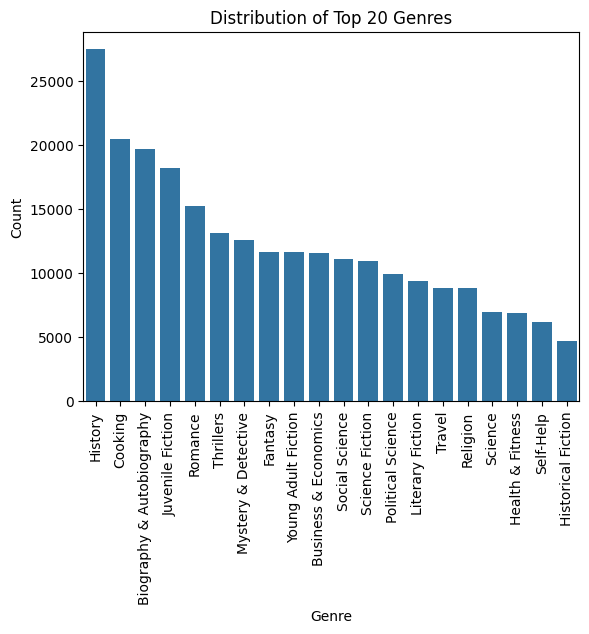

In [4]:
from collections import defaultdict
import pandas as pd
import swifter


NOT_TOP_20 = "not_top_20"


def get_genre(bisac, subdivide_fiction=True):
    bisac = str.upper(bisac)
    if bisac[:3] == "FIC" and subdivide_fiction:
        bisac = bisac[:6]
    else:
        bisac = bisac[:3]
    return genre_dict.get(bisac, NOT_TOP_20)


genres = merged_df["bisacs"].swifter.apply(lambda x: [get_genre(bisac) for bisac in x])
genres = genres.tolist()
genres = [set(genres_inner) for genres_inner in genres]
combined = [genre for genres_inner in genres for genre in genres_inner]
unique_genres = list(set(combined))

genre_counts = defaultdict(int)
for genre_inner in genres:
    for genre in genre_inner:
        genre_counts[genre] += 1
genre_counts.pop(NOT_TOP_20)

genre_counts = sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)
top_genres = [genre for genre, count in genre_counts[:20]]


def get_top_genres(genres):
    genres_in_top_genres = []
    for genre in genres:
        if genre in top_genres:
            genres_in_top_genres.append(genre)
    return genres_in_top_genres


merged_df["genres"] = (
    merged_df["bisacs"]
    .swifter.apply(lambda x: [get_genre(bisac) for bisac in x])
    .swifter.apply(get_top_genres)
)
merged_df.drop(columns=["bisacs"], inplace=True)
merged_df = merged_df[merged_df["genres"].map(len) > 0]
print(f"Number of books: {merged_df.shape[0]}")

import matplotlib.pyplot as plt
import pandas as pd
import ast
import seaborn as sns

combined = [genre for genres_inner in merged_df["genres"] for genre in genres_inner]
sns.countplot(x=combined, order=pd.Series(combined).value_counts().index)
plt.title("Distribution of Top 20 Genres")
plt.xticks(rotation=90)
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

## Add text excerpts to the dataframe

In [25]:
import ast
import random
from tqdm import tqdm

# only sample 15000 to compute faster; we're sampling 10,000 later anyway
# some books are insufficently long, so we oversample here
sampled_df = merged_df.sample(15000)

df_filename_isbns = pd.read_csv("initial_data/filename_isbns.csv")

filenames = []
isbns = []
for i, row in tqdm(
    df_filename_isbns.iterrows(),
    total=len(df_filename_isbns),
    desc="creating filename to isbn dict",
):
    filenames.append(row["filename"])
    isbn_1d = ast.literal_eval(row["isbns"])
    if len(isbn_1d) == 1 or len(str(isbn_1d[0])) == 13:
        isbns.append(isbn_1d[0])
    else:
        isbn_1d = [str(isbn) for isbn in isbn_1d]
        isbn_1d.sort(key=len, reverse=True)
        isbns.append(isbn_1d[0])

isbn_to_filename = {str(isbn): filename for isbn, filename in zip(isbns, filenames)}


def get_text(isbn):
    if n_words < n_chunks * chunk_len:
        return None

    n_chunks = 10
    chunk_len = 500

    isbn = str(isbn)
    try:
        filename = isbn_to_filename[isbn]
        with open(f"initial_data/books3/{filename}", "r") as f:
            full_text = f.read()
        words = full_text.split()
        n_words = len(words)
        if n_words < n_chunks * chunk_len:
            return None

        chunks = [(i, words[i : i + chunk_len]) for i in range(0, n_words, chunk_len)]

        sampled_chunks = random.sample(chunks, n_chunks)
        sampled_chunks.sort(key=lambda x: x[0])
        combined = [word for i, chunk in sampled_chunks for word in chunk]
        combined_str = " ".join(combined)
        return combined_str

    except Exception as e:
        print(f"Error processing ISBN {isbn}: {e}")
        return None

creating filename to isbn dict: 100%|██████████| 174918/174918 [00:11<00:00, 14912.87it/s]


In [26]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import os


isbns = sampled_df["isbn"].tolist()

with Pool(processes=os.cpu_count()) as pool:
    texts = list(tqdm(pool.imap(get_text, isbns), total=len(isbns)))

sampled_df["text"] = texts

100%|██████████| 15000/15000 [01:14<00:00, 201.02it/s]


## Sample 10000 books

In [27]:
sampled_df = sampled_df.dropna(subset=["text", "summary"])
sampled_df = sampled_df.sample(10000)

## Split into train and test 


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split

train, test = train_test_split(sampled_df, test_size=0.2, random_state=42)
train_index = train.index
sampled_df["split"] = "test"
sampled_df.loc[train_index, "split"] = "train"

sampled_df.to_csv("data/data.csv", index=False)
sampled_df

,isbn,summary,genres,text,split
28783,9780316254045,The stunning new novel by the author of Sway i...,"[Literary Fiction, Historical Fiction]",a brave thing just to take them down and give ...,test
50425,9780743254533,Mark Sundeen needed to stage a comeback. His f...,"[Biography & Autobiography, Biography & Autobi...",we'd shipped three hundred copies. We could no...,train
42275,9780525621645,NATIONAL BESTSELLER - For women approaching or...,"[Health & Fitness, Cooking, Health & Fitness]",condition or have any symptom that may require...,train
114519,9781590513286,"An entertaining exploration of the myths, clai...","[Cooking, Science, Health & Fitness]",means that two of these bars a day contain an ...,test
44172,9780553900101,"Filled with exciting tales of the frontier, th...",[Historical Fiction],of questionable activities. Fanny Baston did n...,train
...,...,...,...,...,...
121526,9781612381053,Canada resident and avid outdoorsman Andrew He...,[Travel],guides. **Yamnuska** (403/678-4164 or 866/678-...,train
38396,9780446569439,Beginning in Ireland in the early years of the...,"[Literary Fiction, Historical Fiction]",it? To have it locked in there night after nig...,train
1998,9780008203771,'Do yourself a favour and read this wonderful ...,"[Historical Fiction, Literary Fiction]",you know she's called Marusya?' asks Masha. 'U...,train
95262,9781462903467,Today people around the world are discovering ...,"[Self-Help, Self-Help]",helping maintain the structural balance of the...,test


In [29]:
sampled_df["text"].apply(lambda x: len(x.split())).value_counts()

text
5000    9176
4928       8
4570       5
4829       5
4911       5
        ... 
4984       1
4517       1
4921       1
4769       1
4646       1
Name: count, Length: 416, dtype: int64

# Vectorizing

## Doc2vec model training

With parameter `min_count=2`; besides that, unlimited vocabulary size

In [1]:
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import pandas as pd


def create_model(df, column_name):
    model = Doc2Vec(
        vector_size=100,
        window=5,
        alpha=0.025,
        min_alpha=0.00025,
        seed=42,
        dm=1,
        dm_concat=1,
        workers=os.cpu_count(),
        epochs=100,
        min_count=2,
    )

    tagged_data = [
        TaggedDocument(
            words=word_tokenize(doc.lower()),
            tags=[str(i)],
        )
        for i, doc in tqdm(
            enumerate(df[column_name]), total=len(df), desc=f"tagging {column_name}"
        )
    ]

    model.build_vocab(tagged_data)
    model.train(
        tagged_data,
        total_examples=model.corpus_count,
        epochs=model.epochs,
        report_delay=1,
    )

    return model


df = pd.read_csv("data/data.csv")
train = df[df["split"] == "train"]

create_model(train, "summary").save("doc2vec_models/summary.model")
create_model(train, "text").save("doc2vec_models/text.model")

tagging text: 100%|██████████| 8000/8000 [03:53<00:00, 34.33it/s]


## Doc2vec vectorizing

In [ ]:
import multiprocessing
import pandas as pd
from gensim.models import Doc2Vec
import pandas as pd
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec
from nltk.tokenize import word_tokenize


df = pd.read_csv("data/data.csv")
train = df[df["split"] == "train"]


def vectorize_text(text):
    model = Doc2Vec.load(f"doc2vec_models/{column_name}.model")
    return model.infer_vector(word_tokenize(text.lower()))


for column_name in ["summary", "text"]:
    num_cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(num_cores)

    df_vectorized = pd.DataFrame(pool.map(vectorize_text, df[column_name]))
    pool.close()
    pool.join()

    df_vectorized.to_csv(f"data/doc2vec_{column_name}.csv", index=False)

## TF-IDF

min_df=2, vocabulary size limit = 25000 (vocabulary size would have been 404623 for text without these; kernel fails when trying to classify on that much data) 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import pandas as pd


df = pd.read_csv("data/data.csv")
train = df[df["split"] == "train"]


for column_name in ["summary", "text"]:
    tfidf = TfidfVectorizer(max_features=25000, min_df=2)
    tfidf.fit(train[column_name])
    # print the size of the volcabulary
    print("vocab size", len(tfidf.vocabulary_))

    df_vectorized = pd.DataFrame(tfidf.transform(df[column_name]).todense())
    df_vectorized.columns = tfidf.get_feature_names_out()
    df_vectorized.to_csv(f"data/tfidf_{column_name}.csv", index=False)

vocab size 25000
vocab size 25000


## PCA on TF-IDF

- stop words in PCs!
- we don't stem because past tence could tell us it's a biography, etc
- standardize data and aruge why it won't hurt here or in classification

finished reading summary
the        0.619419
of         0.401418
in         0.130647
his        0.120147
war        0.096597
and        0.089933
history    0.081830
was        0.071432
he         0.064554
world      0.062818
dtype: float64
her      0.567017
she      0.384256
his      0.123227
he       0.115217
but      0.096384
is       0.093237
when     0.078191
has      0.068381
woman    0.066404
was      0.060225
dtype: float64
length of explained variance ratio: 8000
75% of variance captured with 2912 components
90% of variance captured with 4807 components


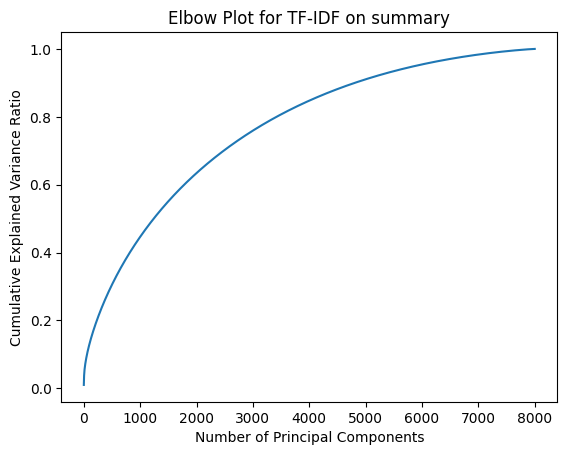

finished reading text
he     0.352618
she    0.350320
her    0.310299
was    0.247033
you    0.245647
to     0.198901
it     0.193978
his    0.182364
my     0.149718
had    0.143913
dtype: float64
you         0.129802
she         0.110628
her         0.094418
cup         0.073186
que         0.071295
teaspoon    0.064923
de          0.056790
your        0.052070
salt        0.050835
add         0.050125
dtype: float64
length of explained variance ratio: 8000
75% of variance captured with 1832 components
90% of variance captured with 3705 components


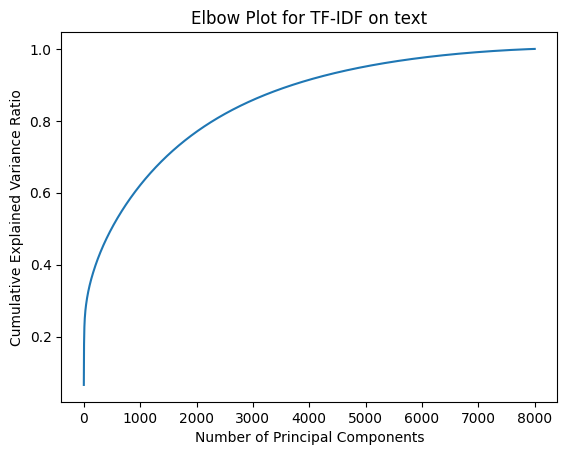

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np


df = pd.read_csv("data/data.csv")
train_index = df[df["split"] == "train"].index

for column_name in ["summary", "text"]:
    df_vectorized = pd.read_csv(f"data/tfidf_{column_name}.csv")
    train = df_vectorized.loc[train_index]
    print(f"finished reading {column_name}")

    pca = PCA()
    pca.fit(train)

    print(
        pd.Series(pca.components_[0], index=df_vectorized.columns).sort_values(
            ascending=False
        )[:10]
    )
    print(
        pd.Series(pca.components_[1], index=df_vectorized.columns).sort_values(
            ascending=False
        )[:10]
    )

    print(f"length of explained variance ratio: {len(pca.explained_variance_ratio_)}")
    cumsum = np.cumsum(pca.explained_variance_ratio_)

    print(f"75% of variance captured with {np.argmax(cumsum > 0.75)} components")
    print(f"90% of variance captured with {np.argmax(cumsum > 0.90)} components")

    plt.plot(cumsum)
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.title(f"Elbow Plot for TF-IDF on {column_name}")
    plt.show()

# Clustering

## k-means

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import ast
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv("data/data.csv")
train_index = df[df["split"] == "train"].index


Y_train = Y[train_index]
Y_test = Y[test_index]
df_data = pd.read_csv("data/tfidf_text.csv")
X_train = df_data.loc[train_index]
X_test = df_data.loc[test_index]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## Spectral

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import spectral_clustering
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

df = pd.read_csv("final_data/data.csv")
train_index = pd.read_csv("final_data/train_index.csv")["0"]
labels = df[df.index.isin(train_index)]["genre"]


for column_name in ["summary", "text"]:
    for vectorizer_type in ["tfidf", "doc2vec"]:
        df_vectorized = pd.read_csv(f"final_data/{vectorizer_type}_{column_name}.csv")
        train = df_vectorized[df_vectorized.index.isin(train_index)]
        scaler = StandardScaler()
        train = scaler.fit_transform(train)

        n_samples = 1000
        random_indices = np.random.choice(train.shape[0], n_samples, replace=False)
        train_sample = train[random_indices]
        labels_sample = labels.reset_index(drop=True)[random_indices]
        distances = pairwise_distances(train_sample, metric="euclidean")

        sigmas = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256]

        for sigma in sigmas:
            affinity_matrix = rbf_kernel(distances, gamma=1 / (2 * sigma**2))
            degree_matrix = np.diag(np.sum(affinity_matrix, axis=1))
            laplacian_matrix = degree_matrix - affinity_matrix
            eigenvalues = np.linalg.eigvals(laplacian_matrix)
            sorted_eigenvalues = np.sort(eigenvalues)
            plt.plot(sorted_eigenvalues, label=f"Sigma: {sigma}")

        plt.xlabel("Number of Eigenvalues")
        plt.ylabel("Eigenvalues")
        plt.title(
            f"Eigenvalues of Laplacian Matrix for {column_name.capitalize()} ({vectorizer_type.capitalize()})"
        )
        plt.legend()
        plt.show()

In [ ]:
from sklearn.cluster import SpectralClustering


n_clusters = 11
sc = SpectralClustering(
    n_clusters=n_clusters,
    # n_components=n_clusters + 1,
    # affinity="rbf",
    affinity="nearest_neighbors",
    # gamma=1 / (2 * sigma**2),
    n_jobs=-1,
)

labels_pred = sc.fit_predict(train)
adjusted_rand_score(labels, labels_pred)

In [ ]:
from sklearn.cluster import KMeans


# get the 11 smallest eignevectors
smallest = np.linalg.eig(laplacian_matrix)[1][:, :11]

# run k-means on smallest
kmeans = KMeans(n_clusters=11, random_state=42)
clusters = kmeans.fit_predict(smallest)

ari = adjusted_rand_score(labels_200, clusters)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Initialize MDS and fit_transform the data
mds = MDS(n_components=2, random_state=42)
embedding = mds.fit_transform(smallest)

# Plot the clusters
plt.figure(figsize=(8, 6))
for i in range(11):
    plt.scatter(
        embedding[clusters == i, 0], embedding[clusters == i, 1], label=f"Cluster {i}"
    )
plt.title("MDS Plot of Clusters")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.show()

# Classification

## Multi-label predication via grid search over logistic regression

- log reg w/ max_iters = 1000
- scaled data
- c_params = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]

### Single datasets

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import ast
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv("data/data.csv")
df["genres"] = df["genres"].apply(ast.literal_eval)
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["genres"])
train_index = df[df["split"] == "train"].index
test_index = df[df["split"] == "test"].index
Y_train = Y[train_index]
Y_test = Y[test_index]


for column_name in ["summary", "text"]:
    for vectorizer_type in ["tfidfpca"]:  # ["doc2vec", "tfidf", "tfidfpca"]:
        filename = (
            f"data/tfidf_{column_name}.csv"
            if vectorizer_type == "tfidfpca"
            else f"data/{vectorizer_type}_{column_name}.csv"
        )
        df_data = pd.read_csv(filename)

        X_train = df_data.loc[train_index]
        X_test = df_data.loc[test_index]

        if vectorizer_type == "tfidfpca":
            n_components = 4807 if column_name == "summary" else 3705
            pca = PCA(n_components=n_components, random_state=42)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

            print("pca done")

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        logreg = LogisticRegression(max_iter=1000)
        multi_target_logreg = MultiOutputClassifier(logreg)
        c_params = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
        param_grid = {"estimator__C": c_params}
        grid_search = GridSearchCV(multi_target_logreg, param_grid, cv=5, n_jobs=-1)

        grid_search.fit(X_train, Y_train)
        print(column_name, vectorizer_type, grid_search.best_params_)
        best_estimator = grid_search.best_estimator_
        Y_pred_proba = best_estimator.predict_proba(X_test)
        Y_pred_proba = np.array(Y_pred_proba)[:, :, 1]
        Y_pred_proba = Y_pred_proba.T

        save_path = f"probability_predictions/{vectorizer_type}_{column_name}.npy"
        np.save(save_path, Y_pred_proba)

pca done
summary tfidfpca {'estimator__C': 0.3}
pca done
text tfidfpca {'estimator__C': 0.1}


### Joint datasets

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import ast
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data/data.csv")
df["genres"] = df["genres"].apply(ast.literal_eval)
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["genres"])
train_index = df[df["split"] == "train"].index
test_index = df[df["split"] == "test"].index
Y_train = Y[train_index]
Y_test = Y[test_index]

In [ ]:
pairs_list = [
    (("tfidf", "summary"), ("doc2vec", "summary"), "summary"),
    (("tfidf", "text"), ("doc2vec", "text"), "text"),
]

for pair_1, pair_2, name in pairs_list:
    df_data = pd.concat(
        [
            pd.read_csv(f"data/{pair_1[0]}_{pair_1[1]}.csv"),
            pd.read_csv(f"data/{pair_2[0]}_{pair_2[1]}.csv"),
        ],
        axis=1,
    )

    X_train = df_data.loc[train_index]
    X_test = df_data.loc[test_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    logreg = LogisticRegression(max_iter=1000)
    multi_target_logreg = MultiOutputClassifier(logreg)
    c_params = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
    param_grid = {"estimator__C": c_params}
    grid_search = GridSearchCV(multi_target_logreg, param_grid, cv=5, n_jobs=-1)

    grid_search.fit(X_train, Y_train)
    print(name, grid_search.best_params_)
    best_estimator = grid_search.best_estimator_
    Y_pred_proba = best_estimator.predict_proba(X_test)
    Y_pred_proba = np.array(Y_pred_proba)[:, :, 1]
    Y_pred_proba = Y_pred_proba.T

    save_path = f"probability_predictions/{name}.npy"
    np.save(save_path, Y_pred_proba)

## Results

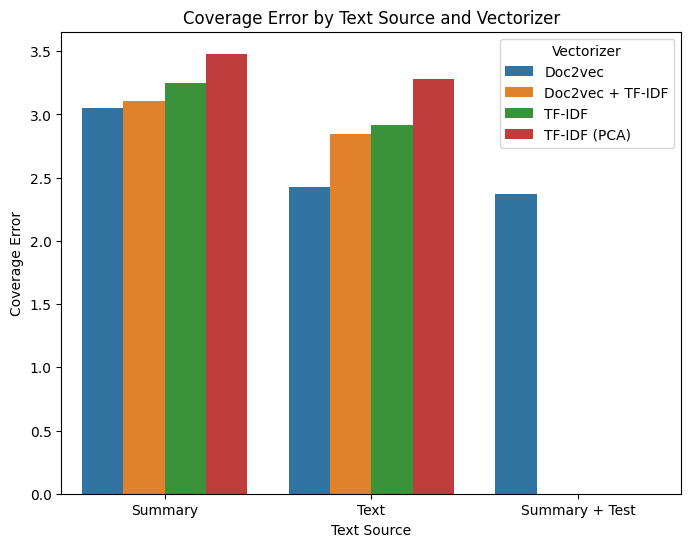

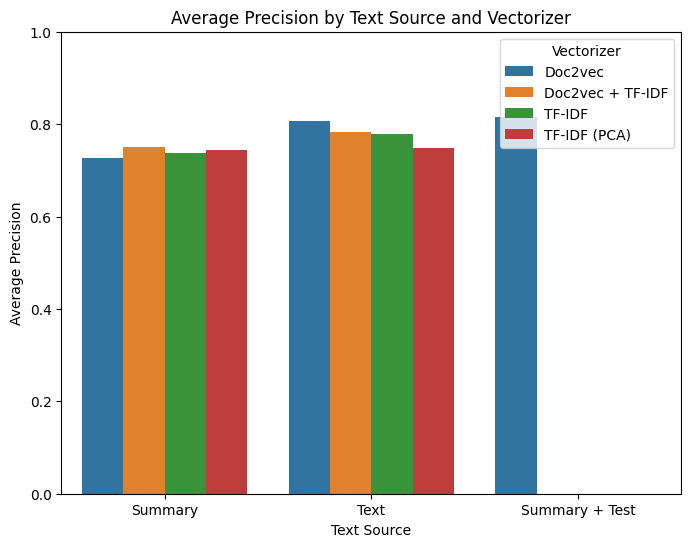

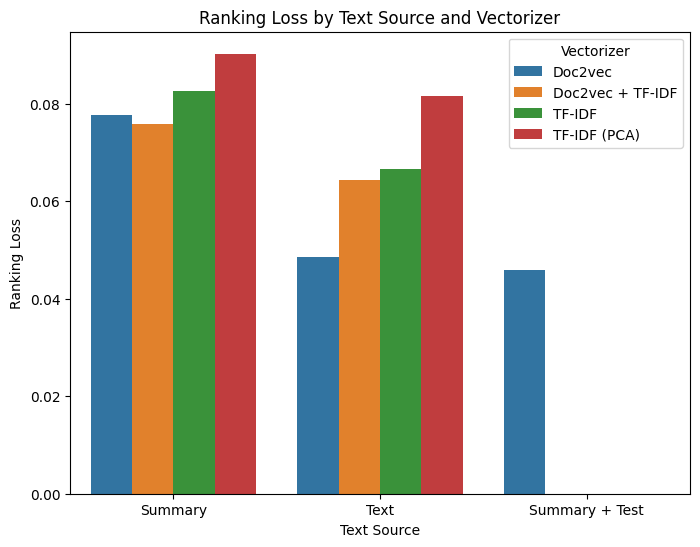

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    coverage_error,
    label_ranking_average_precision_score,
    label_ranking_loss,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)


def plot_metric(metric_name):
    plt.figure(figsize=(8, 6))
    sns.barplot(x="Text Source", y=metric_name, hue="Vectorizer Type", data=results_df)
    plt.title(f"{metric_name} by Text Source and Vectorizer")
    plt.ylabel(metric_name)
    plt.xlabel("Text Source")
    plt.legend(title="Vectorizer")
    if metric_name == "Average Precision":
        plt.ylim(0, 1)
    plt.show()


Y_test = np.load(f"data/Y_test.npy")

vectorizer_types = ["tfidf", "doc2vec", "tfidf + doc2vec"]
column_names = ["summary", "text", "summary + text"]
metrics = [
    coverage_error,
    label_ranking_average_precision_score,
    label_ranking_loss,
]

results = []

trios = [
    ("doc2vec_summary", "Doc2vec", "Summary"),
    ("doc2vec_text", "Doc2vec", "Text"),
    ("doc2vec", "Doc2vec", "Summary + Test"),
    ("summary", "Doc2vec + TF-IDF", "Summary"),
    ("text", "Doc2vec + TF-IDF", "Text"),
    ("tfidf_summary", "TF-IDF", "Summary"),
    ("tfidf_text", "TF-IDF", "Text"),
    ("tfidfpca_summary", "TF-IDF (PCA)", "Summary"),
    ("tfidfpca_text", "TF-IDF (PCA)", "Text"),
]

for filename, vectorizer_type, column_name in trios:
    filename += ".npy"
    Y_pred_proba = np.load(f"probability_predictions/{filename}")

    metrics_values = [metric(Y_test, Y_pred_proba) for metric in metrics]
    results.append(
        {
            "Vectorizer Type": vectorizer_type,
            "Text Source": column_name,
            "Coverage Error": metrics_values[0],
            "Average Precision": metrics_values[1],
            "Ranking Loss": metrics_values[2],
        }
    )

results_df = pd.DataFrame(results)

# Plotting
plot_metric("Coverage Error")
plot_metric("Average Precision")
plot_metric("Ranking Loss")

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

Y_test = np.load(f"data/Y_test.npy")


Y_pred_proba = np.load(f"probability_predictions/doc2vec.npy")
Y_pred = (Y_pred_proba > 0.5).astype(int)

target_names = mlb.classes_
cr = classification_report(Y_test, Y_pred, target_names=target_names, zero_division=0)
print(cr)

                           precision    recall  f1-score   support

Biography & Autobiography       0.49      0.89      0.63       256
     Business & Economics       0.55      0.88      0.68       123
                  Cooking       0.84      0.98      0.90       157
                  Fantasy       0.34      0.90      0.50       115
         Health & Fitness       0.47      0.92      0.62        73
       Historical Fiction       0.28      0.65      0.39        80
                  History       0.53      0.89      0.66       296
         Juvenile Fiction       0.68      0.82      0.74       104
         Literary Fiction       0.32      0.87      0.47       164
      Mystery & Detective       0.42      0.86      0.56       140
        Political Science       0.36      0.87      0.51       106
                 Religion       0.56      0.84      0.67        79
                  Romance       0.36      0.89      0.52       155
                  Science       0.39      0.88      0.54     

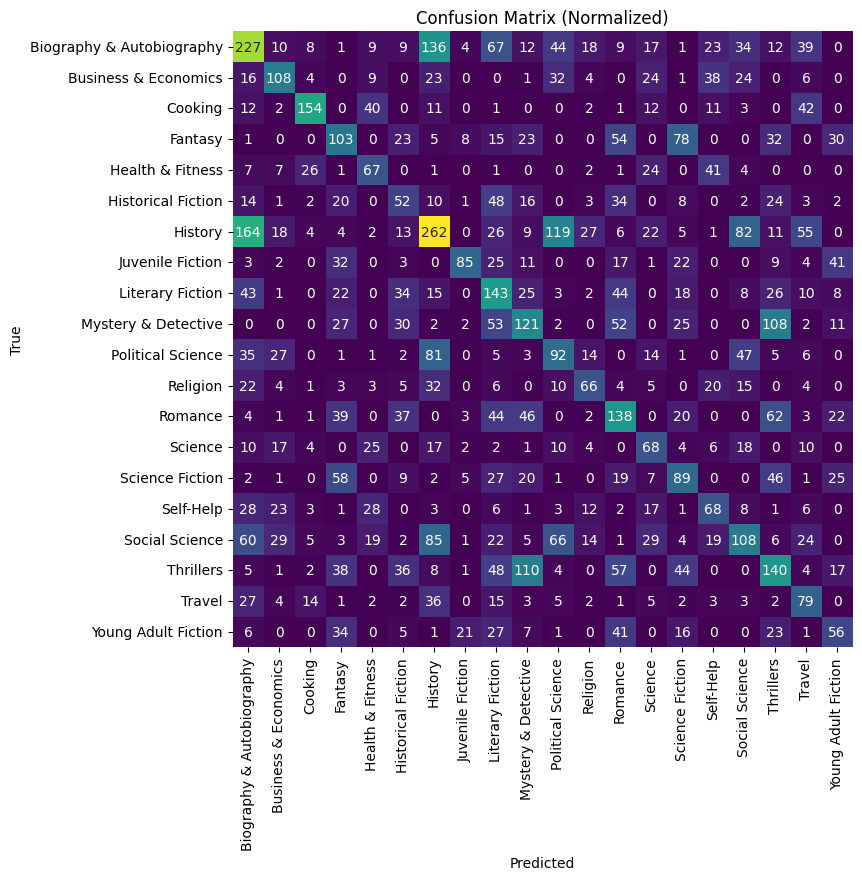

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Y_test = np.load("data/Y_test.npy")
Y_pred_proba = np.load("probability_predictions/doc2vec.npy")
Y_pred_proba = Y_pred_proba > 0.5

matrix = np.dot(Y_test.T, Y_pred)
confusion_matrix_any = pd.DataFrame(matrix, index=mlb.classes_, columns=mlb.classes_)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix_any, annot=True, fmt="d", cmap="viridis", cbar=False)
plt.title(f"Confusion Matrix {'(Normalized)' if normalize else ''}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Salient words in the text

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import ast
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv("data/data.csv")
df["genres"] = df["genres"].apply(ast.literal_eval)
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["genres"])
train_index = df[df["split"] == "train"].index
test_index = df[df["split"] == "test"].index
Y_train = Y[train_index]
Y_test = Y[test_index]

In [24]:
df_data = pd.read_csv("data/tfidf_text.csv")
X_train = df_data.loc[train_index]
X_test = df_data.loc[test_index]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
logreg = LogisticRegression(max_iter=1000)
multi_target_logreg = MultiOutputClassifier(logreg)
c_params = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
param_grid = {"estimator__C": c_params}
grid_search = GridSearchCV(multi_target_logreg, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_

In [39]:
for estimator, genre in zip(best_model.estimators_, mlb.classes_):
    print(genre)
    words = (
        pd.Series(
            estimator.coef_[0],
            index=df_data.columns,
        )
        .sort_values(ascending=False)[:5]
        .index.to_list()
    )
    print(words)

Biography & Autobiography
['my', 'later', 'wrote', 'autobiography', 'júlio']
Business & Economics
['business', 'ceo', 'company', 'elaine', 'companies']
Cooking
['flavor', 'cookbook', 'beetroot', 'cookbooks', 'cooking']
Fantasy
['dwarf', 'mage', 'magic', 'elf', 'druid']
Health & Fitness
['tus', 'yoga', 'asexual', 'tu', 'kombucha']
Historical Fiction
['yonder', 'corbin', 'sharpe', 'henri', 'mariella']
History
['ref', 'elaine', 'army', 'satire', 'whitman']
Juvenile Fiction
['exclaimed', 'dad', 'cried', 'reggie', 'jessie']
Literary Fiction
['imagined', 'vera', 'vanja', 'ida', 'helen']
Mystery & Detective
['inspector', 'murder', 'annja', 'detective', 'murderer']
Political Science
['hun', 'socrates', 'trumbo', 'political', 'javelin']
Religion
['god', 'comida', 'bible', 'gurion', 'rama']
Romance
['hers', 'kiss', 'her', 'hadn', 'she']
Science
['microbes', 'evolution', 'particles', 'fossil', 'species']
Science Fiction
['ship', 'vanja', 'alien', 'airlock', 'sensors']
Self-Help
['choose', 'life',